Snippet to load and visualize the dataset


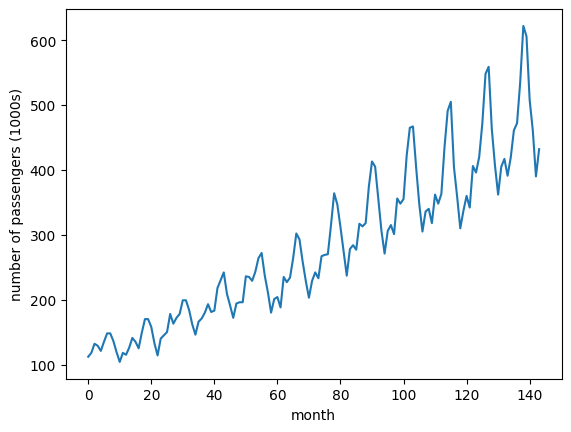

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import blocks
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import blocks
import utils

##use this only if you didn't download yet the csv file##
##!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values
#print(training_set[0])

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

Preprocessing


In [14]:


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 8 #it is tau in the paper
x, y = utils.sliding_windows(training_data, seq_length)


train_size=len(y) -36            #like in the paper
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print(training_data.shape)   
print(dataX.shape)          
print(dataY.shape)
print('TrainX:',trainX.shape)               #batch_size, history_length, num_features)
print(trainY.shape)
print(trainX.size(0))

(144, 1)
torch.Size([135, 8, 1])
torch.Size([135, 1])
TrainX: torch.Size([99, 8, 1])
torch.Size([99, 1])
99


Create real sequences

In [15]:
sequences=utils.real_seq(dataY,seq_length)
sequences=sequences[:99]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)


float32
torch.Size([99, 1, 8])


p.shape: torch.Size([99, 8, 1])


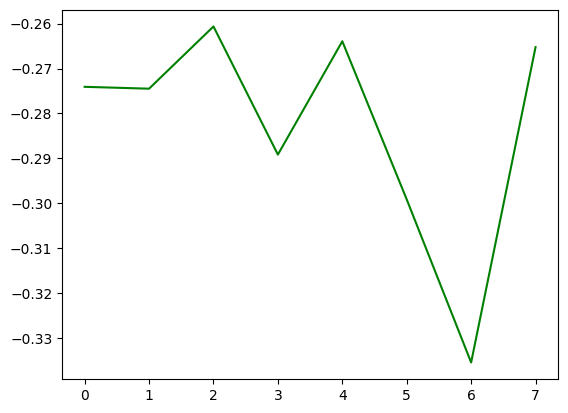

In [16]:


#embed the input
embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1



#extract the number of features
num_features=trainX.size(2)+10  #features+embedding+noise(?)


#Generator
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
p=G(trainX)

p=p.permute(0,2,1)

#plot the results
plt.plot(p[0].detach().numpy(),color="green")
print("p.shape:",p.shape)

# *Train*

### Moment loss

In [17]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

### Path model save

In [18]:
import os
path = "models"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new models directory is created!")

In [19]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

#Hyperparameters
discriminator_lr=0.001
#generator_lr=0.00005
generator_lr=0.0001
num_epochs=200
batch_size=11
criterion = nn.MSELoss()

#Initializations
train_set = TensorDataset(trainX, sequences)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 


#D = blocks.Discriminator()
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
#optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))


#Training
g_losses = []
d_losses = []

for epoch in range(num_epochs):
        g_loss_min=1000000
        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            print("X:",X.shape)
            #print("Y:",Y.shape)
            
              
            # Generate fake data
            fake_data = G(X)
            #fake_label = torch.zeros(Y.size(0))
            '''
            # Train the discriminator
            D.zero_grad()
            d_real_loss = criterion(D(X), torch.ones_like(D(X)))
            d_fake_loss = criterion(D(fake_data.detach()), torch.zeros_like(D(fake_data.detach())))
            d_loss = d_real_loss + d_fake_loss
            d_losses.append(d_loss.item())
            d_loss.backward()
            optimD.step()
            '''
            # Train the generator
            G.zero_grad()
            #g_loss = criterion(D(fake_data), torch.ones_like(D(fake_data)))

            # Add the moment loss
            #g_loss += moment_loss(fake_data, X)
            g_loss = moment_loss(fake_data, Y)
            g_losses.append(g_loss.item())

            if(g_loss<g_loss_min):
                g_loss_min = g_loss
                torch.save(G.state_dict(), 'models/generator.pt')
                torch.save(G, 'models/generator_model.pt')
                print('Improvement-Detected, save-model')

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                #print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                    #(epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
                print("[Epoch %d/%d] [Batch %d/%d] [G loss: %f]" % 
                    (epoch+1, num_epochs, i+1, len(train_loader), g_loss.item()))

X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 1/200] [Batch 1/9] [G loss: 0.768324]
X: torch.Size([11, 8, 1])
[Epoch 1/200] [Batch 2/9] [G loss: 0.788373]
X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 1/200] [Batch 3/9] [G loss: 0.750561]
X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 1/200] [Batch 4/9] [G loss: 0.713938]
X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 1/200] [Batch 5/9] [G loss: 0.679607]
X: torch.Size([11, 8, 1])
[Epoch 1/200] [Batch 6/9] [G loss: 0.739672]
X: torch.Size([11, 8, 1])
[Epoch 1/200] [Batch 7/9] [G loss: 0.768379]
X: torch.Size([11, 8, 1])
[Epoch 1/200] [Batch 8/9] [G loss: 0.755116]
X: torch.Size([11, 8, 1])
[Epoch 1/200] [Batch 9/9] [G loss: 0.790611]
X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 2/200] [Batch 1/9] [G loss: 0.698808]
X: torch.Size([11, 8, 1])
Improvement-Detected, save-model
[Epoch 2/200] [Batch 2/9] [G loss: 0.681363]
X: torch.Size([11, 8,

In [20]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(name, discriminator_loss, generator_loss):
  #print('Train_acc: ',train_acc)
  #print('Train_loss: ',train_loss)
  #device = torch.device("cpu")
  fig, ax1 = plt.subplots(figsize=(20, 6))

  ax1.plot(discriminator_loss, 'o-', label='discriminator loss')
  ax1.plot(generator_loss, '^-', label='generator loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  fig.suptitle(f'Training history {name}')
  print("End-training Generator Loss:",generator_loss[-1])
  print("End-training Discriminator Loss:",discriminator_loss)

End-training Generator Loss: 0.07045452296733856
End-training Discriminator Loss: []


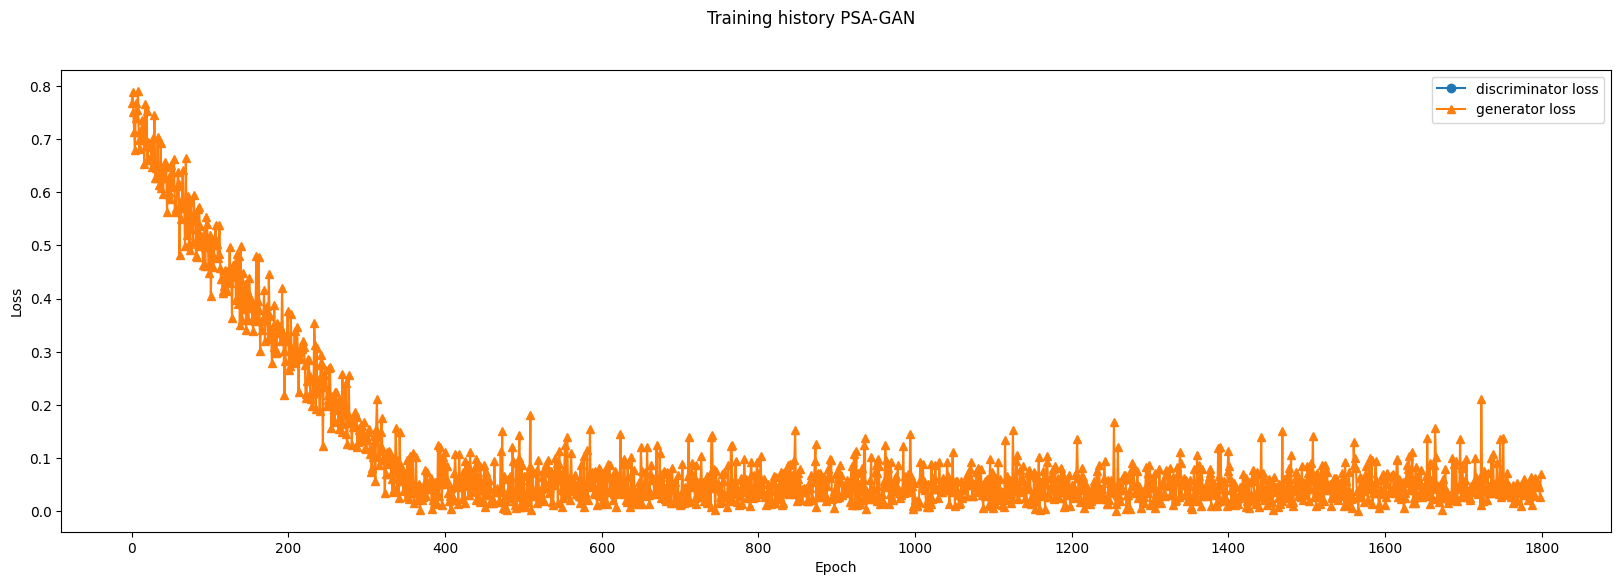

In [21]:


plot_training_history('PSA-GAN',d_losses, g_losses)



In [22]:


# Use the trained generator to generate new time series samples
with torch.no_grad():
    
    
    generated_series = G(trainX[-11:]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()
    #print("generated_series: ",generated_series.shape)



generated_series:  torch.Size([11, 8, 1])


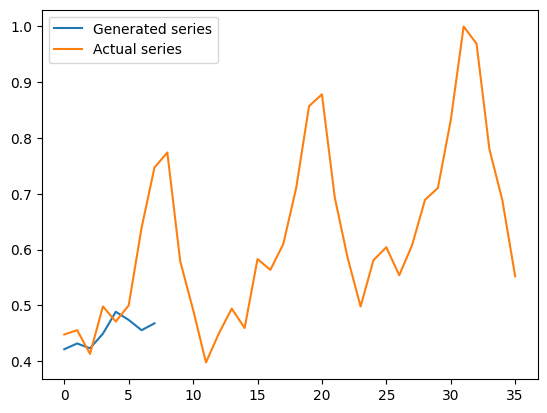

In [23]:
# Plot the generated time series samples

plt.figure()
#for i in range(trainX.size(0)):
#    plt.plot(generated_series[i], label='Generated series')
plt.plot(generated_series[10], label='Generated series')
plt.plot(testY[:trainY.size(0)], label='Actual series')
plt.legend()
plt.show()

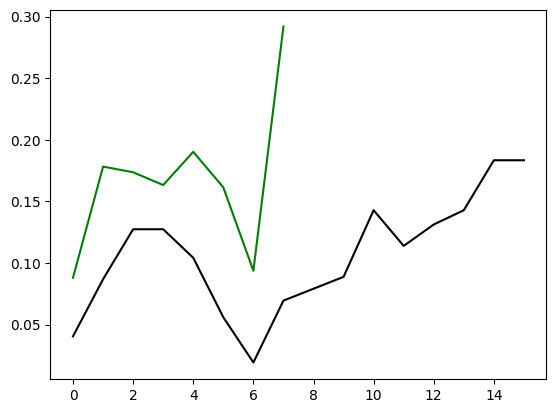

In [24]:
plt.plot(generated_series[0],color="green")
plt.plot(training_data[16:32],color="black")

